# How many e-mails will I get per day?

In [1]:
import numpy as np
import math as math
import warnings

import pandas as pd
from pandas import datetime, Series

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4
# import matplotlib.style as style
# style.available
# style.use('seaborn')

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#set multi output, must be its own separate call
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
df = pd.read_csv('data/email.csv',usecols=['Received','NumEmails'])
df["Received2"] =pd.to_datetime(df["Received"]).dt.normalize()
# df['dow']=pd.to_datetime(df.Received).dt.weekday.astype('str')

df.set_index('Received2',inplace=True)
df = df['2017-08-01':'2017-11-30'].groupby(['Received2'])['NumEmails'].sum()

# df['2017-10-01':'2017-10-31'].plot(figsize=(15,4));
# df['2017-11-01':'2017-11-30'].plot(figsize=(15,4));
# df['2017-12-01':'2017-12-31'].plot(figsize=(15,4));

/home/nathan/anaconda3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/nathan/anaconda3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


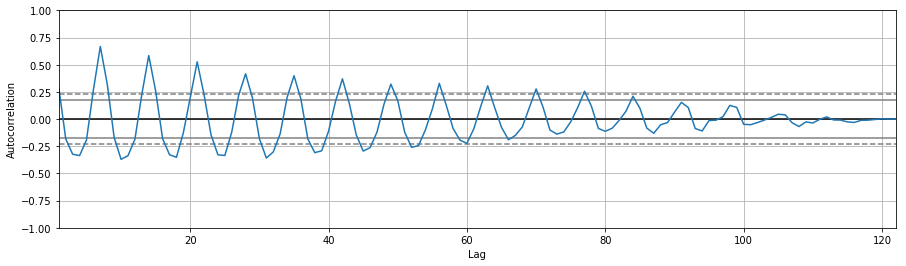

In [4]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,4))
autocorrelation_plot(df);

In [5]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order, bias=0):
    # prepare training dataset
#     X = X.astype('float32')
    train_size = int(len(X) * 0.85)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        numDiff = 2
        diff = difference(history, numDiff)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat, numDiff)
        predictions.append(yhat)
        history.append(test[t])
#         print('predicted=%.0f, expected=%.0f' % (yhat, test[t]))

    df = pd.DataFrame(test)
    df.columns=['act']
    df['yhat'] = predictions
    df['residuals'] = df.apply(lambda r: r.act - r.yhat,axis=1)
    return df

In [6]:
df2 = evaluate_arima_model(df.astype('float32'),(5, 0, 0))
df2.head()

,act,yhat,residuals
Received2,,,
2017-11-12,13.0,23.167016,-10.167016
2017-11-13,34.0,22.994715,11.005285
2017-11-14,24.0,36.160557,-12.160557
2017-11-15,28.0,27.542115,0.457885
2017-11-16,29.0,24.778696,4.221304


Std error 31.82%


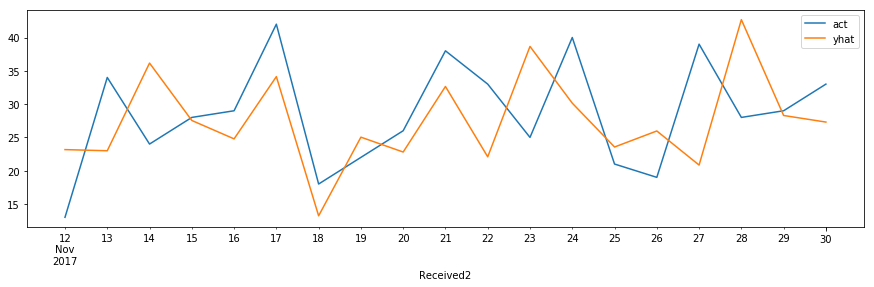

In [9]:
df2.iloc[:,0:2].plot(figsize=(15,4));

rmse = math.sqrt(mean_squared_error(df2.act, df2.yhat))
if not math.isnan(rmse):
    print('Std error {:.2f}%'.format(rmse / np.mean(df2.act) * 100))

,residuals
count,19.000000
mean,0.999316
std,9.250641
min,-14.682152
25%,-5.001211
50%,3.197637
75%,6.785114
max,18.153615


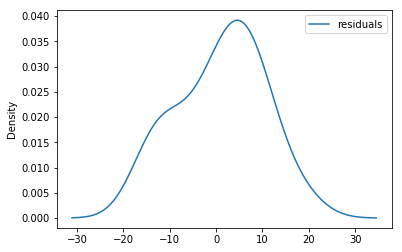

In [15]:
df2[['residuals']].plot(kind='kde');
df2[['residuals']].describe()

AttributeError: 'DataFrame' object has no attribute 'actEmails'

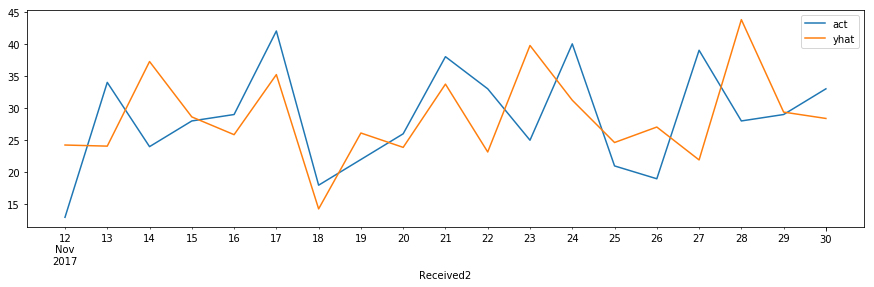

In [16]:
df3 = evaluate_arima_model(df.astype('float32'),(5, 0, 0),1.085000)

df3.iloc[:,0:2].plot(figsize=(15,4));

rmse = math.sqrt(mean_squared_error(df3.actEmails, df3.forecastedEmails))
if not math.isnan(rmse):
    print('Std error {:.2f}%'.format(rmse / np.mean(df3.actEmails) * 100))

In [ ]:
plt.figure(figsize=(15,4))
autocorrelation_plot(df3.residuals);

#there's still some correlation around 7

In [ ]:
l = []
for i in range(100):
    if i == 0:
        j = 5.12
    elif i % 2 == 0:
        j = l[i-1]+7.23
    else:
        j = l[i-1]-2.02
    l.append(j)
#     print("{},{}".format(i,j))

plt.plot(l);
# plt.plot(np.log(l));

In [ ]:
# df2 = evaluate_arima_model(df.astype('float32'),(5, 0, 0))
df = pd.DataFrame(l).astype('float32')
df2 = evaluate_arima_model(pd.DataFrame(l).astype('float32'),(1, 1, 0))
df2.head()